# Gather data

## RDF

In [1]:
import re
import h5py
import iopublic
import numpy as np

PAT = r'_([01][^_]*)_([01]\.[0-9])_'

r = np.linspace(0, 1000, 200)
dr = r[1] - r[0]

def go(simdata, network):
    pos = np.array([(n.x, n.y, n.z) for n in network.neurons])
    sync = np.array(simdata['sync']) # gid, gjd, tfrom, tto, z
    rdf = np.zeros_like(r) # synchronization distribution
    rdf0 = np.zeros_like(r) # position distribution
    rs = np.linalg.norm(pos[sync[:,0].astype(int)] - pos[sync[:,1].astype(int)], axis=1)
    rs0 = np.linalg.norm(pos[:,np.newaxis,:] - pos[np.newaxis, :, :], axis=2).flatten()
    for dist, length in zip(rs, sync[:,3] - sync[:,2]):
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf[idx] += length
    for dist in rs0:
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf0[idx] += 20000
    rdf0[0] = 1
    rdf = rdf / rdf0
    rdf[0] = 0
    return rdf

with h5py.File('imgdata/rdf.h5', 'w') as fout:
    f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
    for tuning in f.keys():
        network = iopublic.get_network_for_tuning(tuning)
        for env in f[tuning].keys():
            print('.', flush=True, end='')
            simdata = f[tuning][env]
            if 'sync' not in simdata:
                continue
            rdf = go(simdata, network)
            fout.create_dataset(f'{tuning}/{env}/rdf', data=rdf)
            fout.create_dataset(f'{tuning}/{env}/r', data=r)
            m = re.search(PAT, tuning)
            ggap = float(m.group(1))
            coef = float(m.group(2))
            fout.create_dataset(f'{tuning}/{env}/ggap', data=ggap)
            fout.create_dataset(f'{tuning}/{env}/coef', data=coef)

....................................................................................................................................

# Dynamical clustering

27


/tmp/ipykernel_17562/4238212572.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).toarray()


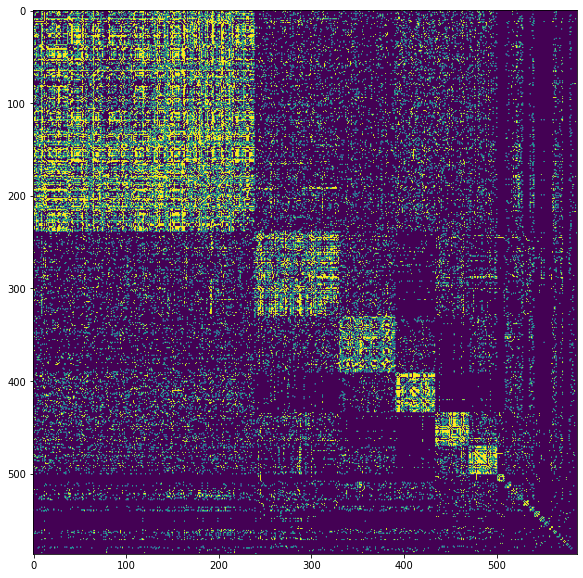

In [1]:
# Collapse

import h5py
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import leidenalg as la
import igraph as ig
import glob

%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

tuning = glob.glob('tuned_networks/2021-12-08-shadow_averages_0.01_0.1*')[0].split('/')[1]
i, j, s, t = f[tuning]['none']['sync'][:,:4].astype(int).T

at = 4900
m = (s <= at) & (t > at)
G = nx.Graph()
G.add_edges_from(zip(i[m], j[m]))
H = ig.Graph.from_networkx(G)
# compute the best partition
#partition = community_louvain.best_partition(G)

partition =  la.find_partition(H, la.CPMVertexPartition,
                                   resolution_parameter = 0.2);

print(max(partition.membership))

ig.plot(partition)

plt.figure(figsize=(15, 10))
o = np.array(partition.membership)
o = o.argsort()
A = nx.adjacency_matrix(G).toarray()
A = A[np.ix_(o, o)]
plt.imshow(A)

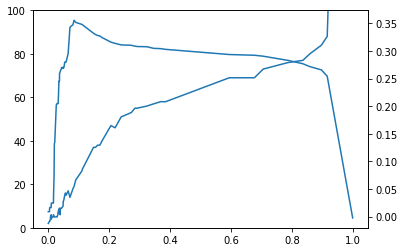

In [2]:
f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

tuning = glob.glob('tuned_networks/2021-12-08-shadow_averages_0.01_1.0_*')[0].split('/')[1]
i, j, s, t = f[tuning]['none']['sync'][:,:4].astype(int).T

at = 4900
m = (s <= at) & (t > at)
G = nx.Graph()
G.add_edges_from(zip(i[m], j[m]))
H = ig.Graph.from_networkx(G)

optimiser = la.Optimiser()
profile = optimiser.resolution_profile(H, la.CPMVertexPartition,
                                       resolution_range=(0,1))
plt.plot([p.resolution_parameter for p in profile], [max(p.membership) for p in profile])
plt.ylim([0, 100])
plt.gca().twinx().plot([p.resolution_parameter for p in profile], [p.modularity for p in profile])

In [3]:
import h5py
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import leidenalg as la
import igraph as ig
import glob
import plotly as py
import plotly.graph_objects as go
import collections

%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

tuning = glob.glob('tuned_networks/2021-12-08-shadow_averages_0.01_0.1*')[0].split('/')[1]
i, j, s, t = f[tuning]['none']['sync'][:,:4].astype(int).T

partitions = {}
for at in range(0, 20000, 100):
    m = (s <= at) & (t > at)
    G = nx.Graph()
    G.add_edges_from(zip(i[m], j[m]))
    H = ig.Graph.from_networkx(G)
    partition =  la.find_partition(H, la.CPMVertexPartition,
                                       resolution_parameter = 0.2);
    partitions[at] = partition

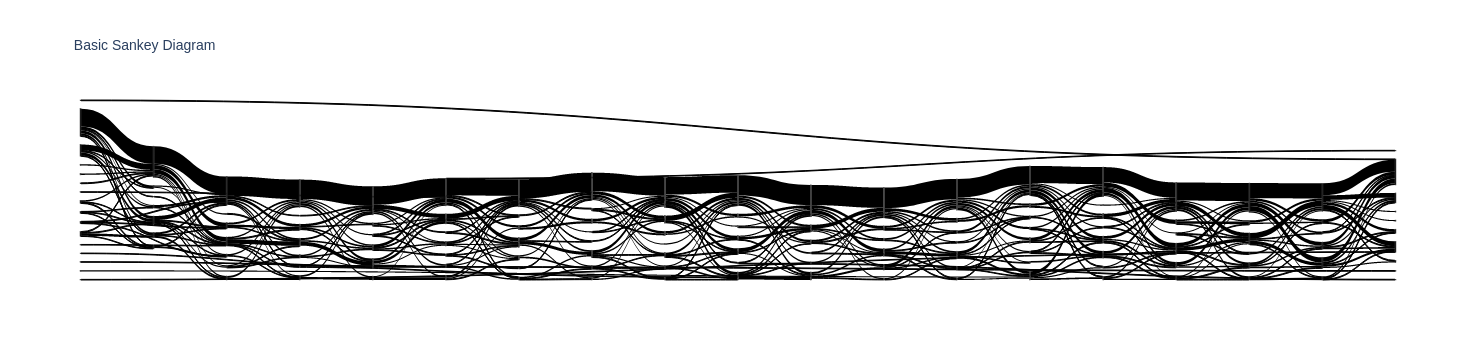

CPU times: user 33.4 ms, sys: 0 ns, total: 33.4 ms
Wall time: 31.1 ms


In [16]:
%%time

threshold = 5

l = {at: p.membership for at, p in partitions.items()}

hits = collections.defaultdict(int)
names = collections.defaultdict(lambda: len(names))

k = 1000
for at in range(0, 20000, k):
    if at + k not in partitions:
        continue
    prv = partitions[at].membership
    nxt = partitions[at + k].membership
    for a, b in zip(prv, nxt):
        hits[names[at, a], names[at + k, b]] += 1

def cmp(kv):
    return kv[0]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 1,
      #line = dict(color = "black", width = 0.5),
      #label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "black"
    ),
    link = dict(
      source = [a for (a, b), v in sorted(hits.items(), key=cmp) if v >= threshold],
      target = [b for (a, b), v in sorted(hits.items(), key=cmp) if v >= threshold],
      value  = [v for (a, b), v in sorted(hits.items(), key=cmp) if v >= threshold],
      color = 'black'
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)

fig.show()

# Plotting

## Synchronization (RDF)

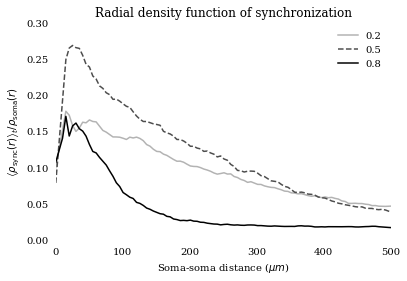

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

plt.rc('font', family='serif')

keys = '''021-12-08-shadow_averages_0.01_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d
2021-12-08-shadow_averages_0.01_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac
2021-12-08-shadow_averages_0.01_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a
2021-12-08-shadow_averages_0.01_0.3_4a2657f8-e7e9-4c15-ae11-a2edcac108fc
2021-12-08-shadow_averages_0.01_0.4_2dc970f8-41c0-4a0d-9a73-083f986023bf
2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86
2021-12-08-shadow_averages_0.01_0.6_b07556b1-21fa-47e6-9021-20072df022c6
2021-12-08-shadow_averages_0.01_0.7_ff526814-9232-4074-8473-16a99676c3ab
2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be
2021-12-08-shadow_averages_0.01_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41
2021-12-08-shadow_averages_0.01_1.0_751ac228-3e2f-4d28-9894-6972386c6977'''.splitlines()

f = h5py.File('imgdata/rdf.h5', 'r')
selected = [2,5,8]
kwargs = [
    dict(color='0.7', ls='solid'),
    dict(color='0.3', ls='dashed'),
    dict(color='k', ls='solid')
]
for i, kw in zip(selected, kwargs):
    rdf = np.array(f[f'{keys[i]}/none/rdf'])
    rdf2 = savgol_filter(rdf, 5, 1)
    r = np.array(f[f'{keys[i]}/none/r'])
    ggap = np.array(f[f'{keys[i]}/none/ggap']).item()
    coef = np.array(f[f'{keys[i]}/none/coef']).item()
    #rdf[0] = np.nan
    plt.plot(r, rdf2, label=f'{coef}', **kw)
plt.xlabel('Soma-soma distance ($\\mu m$)')
plt.ylabel(r'$\left<\rho_{\mathrm{sync}}(r)\right>_t / \rho_{\mathrm{soma}}(r)$')
plt.legend(frameon=False)
plt.ylim([0, 0.3])
plt.xlim([0, 500])
plt.title('Radial density function of synchronization')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(bottom = False, left=False)

# RDF of LFP

In [62]:
import h5py
import iopublic
import numpy as np
import matplotlib.pyplot as plt
import numba

%matplotlib inline

plt.rc('font', family='serif')

@numba.jit(nopython=True, cache=True)
def get_rdf(x, y, r):
    m = r.max()
    rdf = np.zeros_like(r)
    cmin = np.ones_like(r) * 1e10
    cmax = np.ones_like(r) * -1e10
    count = np.zeros_like(r)
    for i in range(len(x)):
        ri = int(x[i] / m * len(r))
        rdf[ri]   += y[i] > 0.5
        count[ri] += 1
        cmin[ri] = min(cmin[ri], y[i])
        cmax[ri] = max(cmax[ri], y[i])
    rdf[count!=0] /= count[count!=0]
    return r, rdf

def get_rdf_for_tuning(tuning):
    print(tuning.split('/')[0])
    network = iopublic.get_network_for_tuning(tuning.split('/')[0])
    vs = np.array(f[tuning]['vsall'])
    Vext = np.array(f[tuning]['Vext'])
    X = np.array(f[tuning]['X'])
    Y = np.array(f[tuning]['Y'])
    Z = np.array(f[tuning]['Z'])
    
    neurons = network.neurons
    
    nx = np.array([n.x for n in neurons])
    ny = np.array([n.y for n in neurons])
    nz = np.array([n.z for n in neurons])
    ndist = np.sqrt((X[:,None] - nx[None,:])**2 + (Y[:,None] - ny[None,:])**2 + (Z[:,None] - nz[None,:])**2).min(1)
    
    mask = ndist < 50

    Vflat = Vext.reshape(-1, Vext.shape[-1])[mask]
    Vflat = (Vflat - Vflat.mean(1)[:,None]) / Vflat.std(1)[:, None]
    dist = np.sqrt((X[mask,None] - X[None,mask])**2 + (Y[mask,None] - Y[None,mask])**2 + (Z[mask,None] - Z[None,mask])**2)
    x = dist.flatten()
    # Vflat shape: (nprobes, 4000)
    corr = np.corrcoef(Vflat)
    y = corr.flatten()
    r = np.linspace(0, x.max(), 100)
    r, rdf = get_rdf(x, y, r)
    
    rdfs = []
    for i in range(0, Vflat.shape[1], 500):
        v = Vflat[:,i:i+500]
        v = (v - v.mean(1)[:,None]) / v.std(1)[:, None]
        corr = np.corrcoef(v)
        y = corr.flatten()
        r_, rdf2 = get_rdf(x, y, r)
        rdfs.append(rdf2)
    rdfs = np.array(rdfs)

    return r, rdf, rdfs

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

keys = '''2021-12-08-shadow_averages_{ggap}_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d/{sim}
2021-12-08-shadow_averages_{ggap}_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac/{sim}
2021-12-08-shadow_averages_{ggap}_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a/{sim}
2021-12-08-shadow_averages_{ggap}_0.3_4a2657f8-e7e9-4c15-ae11-a2edcac108fc/{sim}
2021-12-08-shadow_averages_{ggap}_0.4_2dc970f8-41c0-4a0d-9a73-083f986023bf/{sim}
2021-12-08-shadow_averages_{ggap}_0.5_3447248c-68a1-4860-b512-39fa22a5fa86/{sim}
2021-12-08-shadow_averages_{ggap}_0.6_b07556b1-21fa-47e6-9021-20072df022c6/{sim}
2021-12-08-shadow_averages_{ggap}_0.7_ff526814-9232-4074-8473-16a99676c3ab/{sim}
2021-12-08-shadow_averages_{ggap}_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be/{sim}
2021-12-08-shadow_averages_{ggap}_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41/{sim}
2021-12-08-shadow_averages_{ggap}_1.0_751ac228-3e2f-4d28-9894-6972386c6977/{sim}'''.splitlines()

plots = []

tuning = keys[8].format(ggap='0.0001', sim='none')
r, rdf, rdfs = get_rdf_for_tuning(tuning)
plots.append(dict( r=r, rdf=rdf, rdfs=rdfs, tuning=tuning ))

tuning = keys[2].format(ggap='0.01', sim='none')
r, rdf, rdfs = get_rdf_for_tuning(tuning)
plots.append(dict( r=r, rdf=rdf, rdfs=rdfs, tuning=tuning ))

tuning = keys[8].format(ggap='0.01', sim='none')
r, rdf, rdfs = get_rdf_for_tuning(tuning)
plots.append(dict( r=r, rdf=rdf, rdfs=rdfs, tuning=tuning ))

2021-12-08-shadow_averages_0.0001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be
2021-12-08-shadow_averages_0.01_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a
2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be


[(<matplotlib.patches.Patch object at 0x7fd55a0d1280>, <matplotlib.lines.Line2D object at 0x7fd552d15850>), (<matplotlib.patches.Patch object at 0x7fd552d15070>, <matplotlib.lines.Line2D object at 0x7fd552cfb0a0>), (<matplotlib.patches.Patch object at 0x7fd552cf6760>, <matplotlib.lines.Line2D object at 0x7fd552cfb400>)]


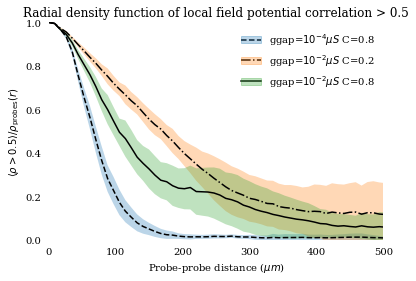

In [177]:
import matplotlib.patches as mpatches

plt.xlim([0, 500])

patches = []
labels = []

def lbl(tuning):
    ggap, cc = tuning.split('_')[2:4]
    return f'ggap=$10^{{{int(np.log10(float(ggap)))}}}\\mu S$ C={cc}'

line = ['--', '-.', '-']
for i, plot in enumerate(plots):
    globals().update(plot)
    
    p, = plt.plot(r, rdfs.mean(0), line[i], color='black', label='a')
    patch = plt.fill_between(r, rdfs.mean(0)-rdfs.std(0), rdfs.mean(0)+rdfs.std(0), alpha=0.3)
    c = patch.get_facecolor()
    patch = mpatches.Patch(color=c)
    patches.append((p, patch))
    labels.append(lbl(tuning))
    
labels.extend(labels)
print(handles)

plt.gca().legend(handles=patches, labels=labels, frameon=False)

plt.xlabel('Probe-probe distance ($\\mu m$)')
plt.ylabel(r'$\left<\rho>0.5\right> / \rho_{\mathrm{probes}}(r)$')
plt.ylim([0, 1])
plt.xlim([0, 500])
plt.title('Radial density function of local field potential correlation > 0.5')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(bottom = False, left=False)

# Synchronization (sync)

In [172]:
import h5py
import iopublic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
tuning = '2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
#tuning = '2021-12-08-shadow_averages_0.001_1.0_751ac228-3e2f-4d28-9894-6972386c6977'
network = iopublic.get_network_for_tuning(tuning)
sync = np.array(f[tuning]['none']['sync'])

Text(0, 0.5, 'Neuron (gid)')

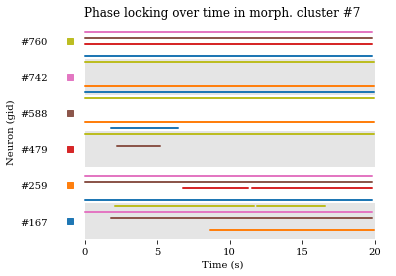

In [181]:
selected = 7

plt.rc('font', family='serif')

C = np.array([neuron.cluster for neuron in network.neurons])
#C = np.random.permutation(C)
mask = (C[sync[:,0].astype(int)] == selected) & (C[sync[:,1].astype(int)] == selected)
i, j, s, t = sync[mask, :4].astype(int).T
neurons = list(sorted(set(i) | set(j)))
ii = np.array([neurons.index(x) for x in i])
jj = np.array([neurons.index(x) for x in j])

#plt.figure(figsize=(14, 10))

cmap = plt.get_cmap('tab10')

def getc(i):
    return cmap(i / len(neurons))
    if i % 2 == 0:
        return '0.9'
    return 'white'

ticks = []
ticklabels = []

for idx, I in enumerate(neurons):
    #plt.axhline(idx*I0, color='black', lw=1)
    I0 = len(neurons)
    ticks.append(I0*idx + I0 / 2)
    ticklabels.append(f'#{I}')
    plt.plot(-1, idx*I0 + I0/2, 's', color=getc(idx))
    if idx % 2 == 0: 
        plt.fill_between([0, 20], [I0*idx, I0*idx], [I0*idx+I0, I0*idx+I0], color='black', alpha=0.1, edgecolor="none")
    for jdx, J in enumerate(neurons):
        m = (i == I) & (j == J)
        for ss, tt in zip(s[m], t[m]):
            plt.plot([ss/1e3, tt/1e3], [0.5+I0*idx + jdx, 0.5+I0*idx + jdx], color=getc(jdx), lw=2, solid_capstyle='round')
#plt.axhline(idx*I0+I0, color='black', lw=1)

#plt.axvline(0, color='black', lw=1)

plt.yticks(ticks, ticklabels)
plt.ylim([ticks[0]-I0/2-0.1, ticks[-1]+I0/2+0.1])      
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(left=False)

plt.title(f'Phase locking over time in morph. cluster #{selected}')
plt.xlabel('Time (s)')
plt.ylabel('Neuron (gid)')

# Control

2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be


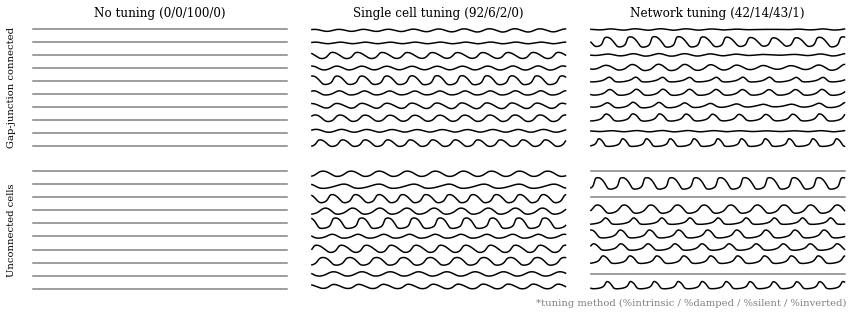

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font', family='serif')
Csel = 32
th = 1

f = h5py.File('imgdata/control_tuning.h5', 'r')
for key in f.keys():
    print(key)

    tuning_methods = [
        dict(key='none', idx=0, name='No tuning'),
        dict(key='sc',   idx=1, name='Single cell tuning'),
        dict(key='tune', idx=2, name='Network tuning')
    ]

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0, hspace=0.1)
    #plt.suptitle(f'{key}')
    C = np.array(f[key]['C'])
    for entry in tuning_methods:
        conn = np.array(f[key][entry['key']]['conn']).ptp(1) > th
        unconn = np.array(f[key][entry['key']]['unconn']).ptp(1) > th
        Nint = (conn & unconn).sum() / len(conn) * 100
        Ndamp = (conn & ~unconn).sum() / len(conn) * 100
        Ninv = (~conn & unconn).sum() / len(conn) * 100
        Nsilent = (~conn & ~unconn).sum() / len(conn) * 100
        ax[0, entry['idx']].set_title(f'{entry["name"]} ({Nint:.0f}/{Ndamp:.0f}/{Nsilent:.0f}/{Ninv:.0f})')
        for k in 'conn', 'unconn':
            vs = np.array(f[key][entry['key']][k])
            
            vs = vs[Csel == C]
            n = vs.shape[1]
            t = np.arange(n)
            m = vs.shape[0]
            a = ax[int(k == 'conn'), entry['idx']]
            for i, v in enumerate(vs):
                v = (v - v.mean()) / 20
                color = 'black'
                if np.isnan(v).any() or v.ptp() < th / 20:
                    color = '0.5'
                    v = np.zeros_like(v)
                a.plot(t[-1000:], i + v[-1000:], color=color)
                a = ax[1 - int(k == 'conn'), entry['idx']]
                #a.set_title(f'{"connected" if k == "conn" else "unconnected"}')
            
            a.set_xticks([])
            a.set_yticks([])
            a.spines['top'].set_visible(False)
            a.spines['right'].set_visible(False)
            a.spines['bottom'].set_visible(False)
            a.spines['left'].set_visible(False)
    ax[0, 0].set_ylabel('Gap-junction connected')
    ax[1, 0].set_ylabel('Unconnected cells')
    ax[1,2].set_xlabel('*tuning method (%intrinsic / %damped / %silent / %inverted)', horizontalalignment='right', position=(0.96,15), color='gray')
    break

## IR Space

20 *
62 x
180 1
376 +
547 D


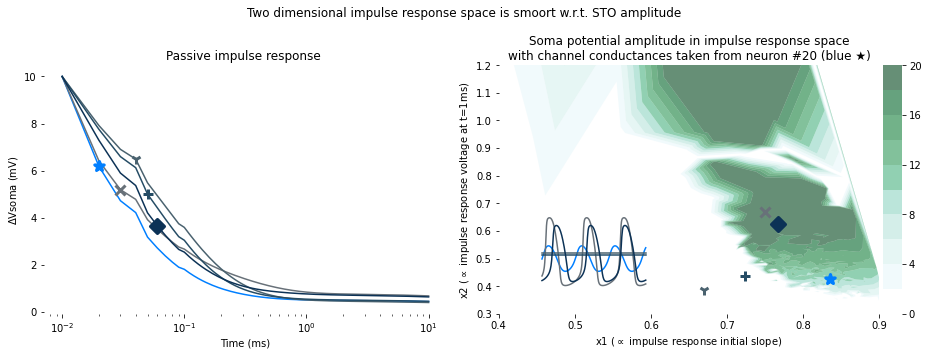

In [25]:
# IR Space

import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

colors = plt.get_cmap('BuGn')(np.linspace(0, 1, 11))
colors[0] = (1, 1, 1, 1)
#colors[-1] = (1, 0, 0, 1)
cm = ListedColormap(colors)

%matplotlib inline

Csel = 32

f = h5py.File('imgdata/control_tuning.h5', 'r')
tuning = '2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
simdata = f[tuning]
vs = np.array(simdata.get('gid20/unconn'))
x1 = np.array(simdata.get('x1'))
x2 = np.array(simdata.get('x2'))
C = np.array(simdata.get('C'))
vstune = np.array(simdata.get('vstune'))

#gid20 = np.sqrt((x1-x1[20])**2 + (x2-x2[20])**2)
#gid20[gid20>1] = 1
ptp20 = vs[20].ptp()
gid20 = vs.ptp(1)
gid20 = np.nan_to_num(gid20)

fig, ax = plt.subplots(ncols=2, figsize=(13, 5))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)

gid20[gid20 >= 20] = 19
tcf = ax[1].tricontourf(x1, x2, gid20, cmap=cm, levels=11, alpha=.6, antialiased=True)

markers = '*x1+D'
ai = ax[1].inset_axes([0.1, 0.1, 0.3, 0.3])
for i, gid in enumerate([20] + list(np.where(C == Csel)[0][::2][:4])):
    t = (np.arange(len(vstune[gid])) + 1) * 0.01
    if i == 0:
        cc = c = '#007fff'
    else:
        cc = f'{(i-1)/4:.1f}'
        c = 'black'
        cc = c = np.array(plt.get_cmap('Blues')(i/5))
        c[:3] /= 2
    ax[0].plot(t, 10 - vstune[gid], color=cc)
    l = 1 + i
    print(gid, markers[i])
    ax[0].scatter(t[l],(10 - vstune[gid])[l], [100], marker=markers[i], linewidths=[3], color=cc, zorder=100)
    ax[1].scatter(x1[gid], x2[gid], [100], marker=markers[i], linewidths=[3], color=c)
    ai.plot(vs[gid, :300], color=cc)
ax[0].set_xscale('log')
ai.axis('off')
#ax[0].set_yscale('log')

#ax[1].scatter(x1[20], x2[20], [100], marker='*', linewidths=[3], color='red')

ax[1].set_xlim([0.4, 0.9])
ax[1].set_ylim([0.3, 1.2])
ax[1].set_xlabel('x1 ($\\propto$ impulse response initial slope)')
ax[1].set_ylabel('x2 ($\\propto$ impulse response voltage at t=1ms)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
plt.tick_params(left=False, bottom=False)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
plt.tick_params(left=False, bottom=False)

ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('$\\Delta$Vsoma (mV)')
#ax[0].set_xlim([1, len(vstune[0])])

cb = fig.colorbar(tcf, cax=cax, orientation='vertical', )
cb.outline.set_visible(False)

ax[0].set_title('Passive impulse response ')
ax[1].set_title('Soma potential amplitude in impulse response space\nwith channel conductances taken from neuron #20 (blue ★)')
plt.suptitle('Two dimensional impulse response space is smoort w.r.t. STO amplitude')
plt.tight_layout();

plt.rcParams['figure.facecolor'] = 'white'

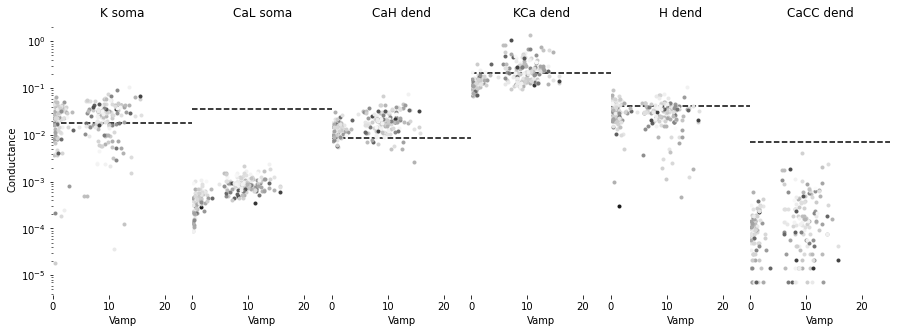

In [105]:
import json
import h5py
import matplotlib.pyplot as plt
import numpy as np

selected = '2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
f = h5py.File('imgdata/control_tuning.h5', 'r')
x1 = np.array(simdata.get('x1'))
x2 = np.array(simdata.get('x2'))
simdata = f[selected]

names = 'scal_ks', 'scal_cal', 'scal_cah', 'scal_kca', 'scal_h', 'scal_cacc'
zeros = 0.015 * 1.2, \
        0.030 * 1.2, \
        0.010 * 1.7 / 2, \
        0.200 * 0.7 * 1.5, \
        0.025 * 1.7, \
        0.007
readable = 'K soma', 'CaL soma', 'CaH dend', 'KCa dend', 'H dend', 'CaCC dend'

cm = plt.get_cmap('gray')

fig, ax = plt.subplots(ncols = len(names), figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0)

with open(f'tuned_networks/{selected}') as f:
    tuning = json.load(f)
for gid, (mod, pop) in enumerate(zip(tuning['mods'], tuning['subpops'])):
    if gid % 3 != 0:
        continue
    #if abs(pop['vamp_shadow'] - 10) < 2:
    #    pass
    #else:
    #    continue
    if not all(k in names for k in mod):
        continue
    for k, v in mod.items():
        i = names.index(k)
        v1 = pop['vamp_shadow']
        v2 = (x1[gid] - 0.4) * 2
        ax[i].plot(v1, v * zeros[i], '.', color=cm(v2))
for i, (n, z) in enumerate(zip(readable, zeros)):
    ax[i].set_title(n)
    ax[i].set_xlim([0, 25])
    ax[i].axhline(z, ls='--', zorder=-100, color='black')
    ax[i].set_yscale('log')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    if i > 0:
        #ax[i].set_yticks([])
        #plt.setp(ax[i].get_xticklabels(), visible=False)
        ax[i].yaxis.set_ticks_position('none')
    ax[i].set_xlabel('Vamp')
ax[0].set_ylabel('Conductance');

# Entropy plots

In [1]:
import h5py
import iopublic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/llandsme/henkdenktenk/database.h5', 'r')

for key in f.keys():
    print(key)
    for k in f[key].keys():
        print(' -', k, '(', ', '.join(f[key][k].keys()), ')')

2021-12-08-shadow_averages_0.001_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d
 - spike1s ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
 - spike1s_gaba ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
2021-12-08-shadow_averages_0.001_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac
 - spike1s ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
 - spike1s_gaba ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
2021-12-08-shadow_averages_0.001_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a
 - spike1s ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
 - spike1s_gaba ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
2021-12-08-shadow_averages_0.001_0.3_4a2657f8-e7e9-4c15-ae11-a2edcac108fc
 - spike1s ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
 - spike1s_gaba ( Vext, X, Xplane, Y, Yplane, Z, at, sync, time, vsall, w )
2021-12-08-shadow_averages_0.001_0.4_2dc970f8-41c0-4a0d-9a73-083f986023bf
 - spike1s ( Vext, X, Xplane, Y, Yplane, Z

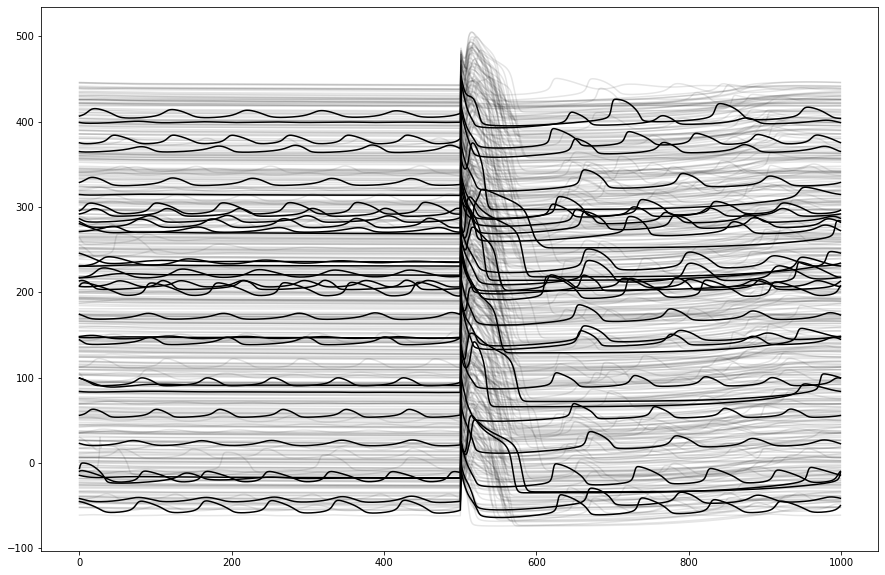

In [7]:
plt.figure(figsize=(15, 10))
selected = '2021-12-08-shadow_averages_0.001_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac/spike1s_gaba'
selected = '2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86/spike1s_gaba'
selected = '2021-12-08-shadow_averages_0.001_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41/spike1s_gaba'
simdata = f[selected]
vsall = np.array(simdata['vsall'])
for i in range(500):
    v = vsall[i,500:-500].reshape(-1, 1000)[10]
    a = v[-10:].ptp()
    if a < 1:
        plt.plot(v/1+i, color='black', alpha=0.1)
        continue
    plt.plot(v/1+i, color='black')

In [20]:
plt.plot(np.isnan(vsall).mean(0))
plt.xscale('log')

NameError: name 'vsall' is not defined

# Synchronization with spikes

In [44]:
import h5py
import iopublic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/llandsme/henkdenktenk/database.h5', 'r')
#tuning = '2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
tuning = '2021-12-08-shadow_averages_0.001_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac'
tuning = '2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
tuning = '2021-12-08-shadow_averages_0.001_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41'
#tuning = '2021-12-08-shadow_averages_0.001_1.0_751ac228-3e2f-4d28-9894-6972386c6977'
network = iopublic.get_network_for_tuning(tuning)


In [52]:
vext = np.array(f[tuning]['spike1s_gaba']['Vext'])
vext = vext[:,:,100:-100].reshape(*vext.shape[:2], -1, 200)
print(vext.shape)

(64, 64, 19, 200)


In [18]:
# cluster 1 - outward growth
# cluster 10 - globular
# cluster 58 -
# cluster 60 - small

plt.figure(figsize=(15,10))
for i in range(0, vext.shape[0], 10):
    for j in range(0, vext.shape[1], 10):
        #for k in range(0, vext.shape[2], 3):
        v = vext[i, j].mean(0)
        if abs(v).max() > 0.01:
            continue
        plt.plot(v, alpha=0.1, color='k')
        
v = vext.mean(0).mean(0).mean(0)
plt.plot(v, color='k')

NameError: name 'vext' is not defined

<Figure size 1080x720 with 0 Axes>

# Comparison with NV19

(7, 980)
(7, 92)


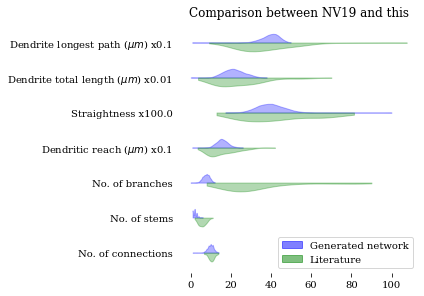

In [19]:
import collections
import gzip
import json
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import skewnorm

plt.rc('font', family='serif')

expected_max_for_n92 = np.random.normal(size=(10000, 92)).max(0).mean()

LC = 'b'
RC = 'g'

def leftviolin(data, positions):
    v1 = plt.violinplot(data, points=40, positions=positions, vert=False,
                   showmeans=False, showextrema=False, showmedians=False)
    for b in v1['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 1])
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], m, np.inf)
        b.set_color(LC)

def rightviolin(data, positions):
    v2 = plt.violinplot(data, points=40, positions=positions, vert=False,
                   showmeans=False, showextrema=False, showmedians=False)
    for b in v2['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 1])
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], -np.inf, m)
        b.set_color(RC)

def get_stats(filename):
    with gzip.open(filename, 'rt') as f:
        network = json.load(f, object_hook=lambda d:SimpleNamespace(**d))
    data = []
    for neuron in network.neurons:
        #neuron:           ['id', 'traces', 'tree', 'x', 'y', 'z']
        #neuron.traces[*]: ['direct_length', 'global_from', 'global_to', 'local_from', 'local_to', 'trace', 'trace_length']
        #neuron.tree[*]:   [dict_keys(['gj', 'old_id', 'seg_id', 'x', 'y', 'z'])
        p = np.array([neuron.x, neuron.y, neuron.z])
        allpoints = np.array([[p.x, p.y, p.z] for trace in neuron.traces for p in trace.trace ])
        soma = neuron.tree[0].seg_id
        parent_counter = collections.Counter(seg.parent for seg in neuron.tree if hasattr(seg, 'parent'))
        max_reach = np.sqrt(((allpoints - p)**2).sum(1)).max()
        longest_path = max(trace.trace_length for trace in neuron.traces)
        seg_lengths = [np.linalg.norm([
            seg.x-neuron.tree[seg.parent].x,
            seg.y-neuron.tree[seg.parent].y,
            seg.z-neuron.tree[seg.parent].z]) for seg in neuron.tree[1:]]
        data.append(dict(
            nconn=len(neuron.traces),
            nstems=parent_counter[soma],
            nbranch=sum(c-1 for p, c in parent_counter.items() if p != soma),
            reach=max_reach,
            straightness=max_reach/longest_path,
            total_length=sum(seg_lengths),
            longest_path=longest_path,
            ))
    return data

def nv19_stats_v2():
    data = []
    def N(min_, median_, mean_, max_):
        a = (max_ - mean_) / expected_max_for_n92
        b = (min_ - mean_) / expected_max_for_n92
        sd = (abs(a) + abs(b)) / 2
        return np.random.normal(mean_, sd)
    for _i in range(1000):
        data.append(dict(
            nconn=N(2, 10, 10, 15),
            nstems=N(1, 6, 7, 12),
            nbranch=N(5, 40, 30, 100),
            reach=N(65, 121, 139, 256),
            straightness=N(0.129, 0.368, 0.42, 0.813),
            total_length=N(1260, 2311, 2635, 7006),
            longest_path=N(170, 330, 367.7, 906),
            ))
    return data

def nv19_stats():
    data = []
    def N(min_, median_, mean_, max_):
        a = (max_ - mean_) / expected_max_for_n92
        b = (min_ - mean_) / expected_max_for_n92
        sd = (abs(a) + abs(b)) / 2
        return np.random.normal(mean_, sd)
    with open('Vrieler19.csv') as f:
        header = next(f).strip().split(',')
        Row = collections.namedtuple('Row', header)
        def conv(s):
            try:
                return float(s)
            except:
                return s
        for line in f:
            #if not 'VIRUS' in line: continue
            row = Row(*map(conv, line.strip().split(',')))
            data.append(dict(
                nconn=N(2, 10, 10, 15),
                nstems=row.n_stems,
                nbranch=row.n_branches,
                reach=row.maxReach,
                straightness=row.straightness,
                total_length=row.dend_totalLength,
                longest_path=row.max_pathLength
                ))
    return data

def tr(data):
    keys = list(data[0].keys())
    values = []
    for kv in data:
        assert(list(kv.keys()) == keys)
        values.append(list(kv.values()))
    values = np.array(values).T
    print(values.shape)
    return dict(zip(keys, values))

factors = np.array([1, 1, 1, 10, .01, 100, 10])
violin_positions = np.arange(len(factors))+1

stats = tr(get_stats("networks/4a2657f8-e7e9-4c15-ae11-a2edcac108fc.json.gz"))
leftviolin(np.array(list(stats.values())).T/factors, violin_positions)

#stats = tr(get_stats("networks/d1666304-c6fc-4346-a55d-a99b3aad55be.json.gz"))
stats = tr(nv19_stats())
rightviolin(np.array(list(stats.values())).T/factors, violin_positions)

ticks = list(stats.keys())
ticks[ticks.index('total_length')] = r'Dendrite total length ($\mu{}m$)'
ticks[ticks.index('longest_path')] = r'Dendrite longest path ($\mu{}m$)'
ticks[ticks.index('reach')] = r'Dendritic reach ($\mu{}m$)'
ticks[ticks.index('nconn')] = r'No. of connections'
ticks[ticks.index('nstems')] = r'No. of stems'
ticks[ticks.index('nbranch')] = r'No. of branches'
ticks[ticks.index('straightness')] = r'Straightness'
yticks = [(f'{n} x{round(1/f, 4)}' if f > 1 else f'{n} x{1/f}') if f != 1 else n for n,f in zip(ticks, factors) ]
plt.yticks(violin_positions, yticks)#, rotation='vertical')

a = 0.5
plt.legend(
        [mpatches.Patch(color=LC, alpha=a), mpatches.Patch(color=RC, alpha=a)],
        ['Generated network', 'Literature'],
        loc='lower right'
        )
plt.tight_layout()
plt.title('Comparison between NV19 and this')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(left=False)

plt.show()